# Домашняя работа №8

#### Задание
    Попробуйте улучшить работу нейронной сети рассмотренной в методическом пособии. Приложите анализ. Приложете лучшее сгенерированное изображение к уроку.
    Обратите внимание для запуска нейронной сети понадобиться tensorflow 2.1.0 и минимум 8gb опер. памяти(если запускать на процессоре).

**Я сделал VAE для CIFAR10**

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

#### Датасет CIFAR

In [2]:
# разделение тренировочной и тестовой выборки
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'тренировочные примеры')
print(X_test.shape[0], 'тестовые примеры')

num_classes = 10
# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# X_train /= 255
# X_test /= 255

X_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


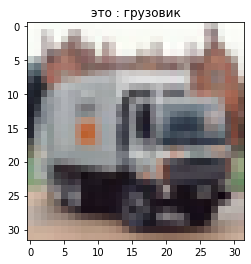

In [3]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
N = 11

plt.imshow(X_test[N][:,:,:])
plt.title('это : '+classes[np.argmax(y_test[N,:])])
plt.show()

## Строим слой семплирования sampling layer


In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Строим энкодер encoder


In [5]:
latent_dim = 512

encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(3, (2, 2), activation="relu", padding="same")(encoder_inputs)
x = layers.Conv2D(32, (2, 2), activation="relu", strides=(2, 2), padding="same")(x)
# x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 3)    39          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 32)   416         ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 32)   9248        ['conv2d_1[0][0]']               
                                                                                            

## Строим свой decoder


In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_1 (Dense)             (None, 8192)              4202496   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       3689

## Создаем класс модель по `Model` с особым шагом *обучения* `train_step`


In [7]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 32 * 32
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }



## Учим VAE


In [8]:
cifar = np.concatenate([X_train, X_test], axis=0)
cifar = cifar.astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [38]:
vae.fit(cifar, epochs=50, batch_size=600)  # 570

Epoch 1/25
100/100 [==============================] - 8s 79ms/step - loss: 572.8873 - reconstruction_loss: 570.9350 - kl_loss: 1.9523
Epoch 2/25
100/100 [==============================] - 8s 78ms/step - loss: 572.7805 - reconstruction_loss: 570.8370 - kl_loss: 1.9435
Epoch 3/25
100/100 [==============================] - 8s 78ms/step - loss: 572.5849 - reconstruction_loss: 570.6460 - kl_loss: 1.9389
Epoch 4/25
100/100 [==============================] - 8s 78ms/step - loss: 572.7535 - reconstruction_loss: 570.8134 - kl_loss: 1.9401
Epoch 5/25
100/100 [==============================] - 8s 78ms/step - loss: 572.2488 - reconstruction_loss: 570.3185 - kl_loss: 1.9303
Epoch 6/25
100/100 [==============================] - 8s 78ms/step - loss: 572.1159 - reconstruction_loss: 570.1960 - kl_loss: 1.9198
Epoch 7/25
100/100 [==============================] - 8s 78ms/step - loss: 572.0794 - reconstruction_loss: 570.1645 - kl_loss: 1.9149
Epoch 8/25
100/100 [==============================] - 8s 78ms/

### Для тестирования результатов погенерируем скрытый вектор

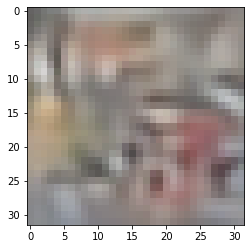

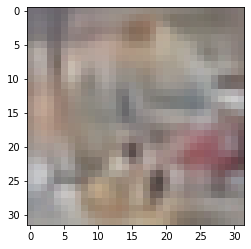

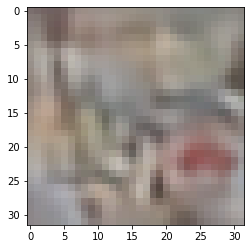

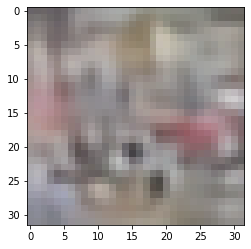

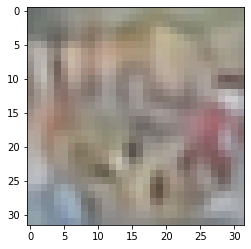

In [47]:
for i in range(5):
    z_sample = np.array([np.random.rand(latent_dim)])
    x_decoded = decoder.predict(z_sample, verbose=0)
    plt.imshow(x_decoded.reshape((32, 32, 3)))
    plt.show()